## # Save Each Numpy Frame as PNG Image

In [2]:
import numpy as np
from numpy import unravel_index
from PIL import Image
import os
import itertools
from tqdm import tqdm

import matplotlib.pyplot as plt
from skimage import img_as_float
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error

from scipy.spatial import distance

import mxnet as mx

In [2]:
set_t = 'testing'
frames_np = np.load(f'{set_t}_videos/{set_t[:-3]}_targets_warped.npy')
frames_np.shape

(3527, 96, 96, 3)

In [3]:
os.chdir('/home/soyorh/Desktop/studyforrest/Preprocessing steps')
os.makedirs('all_MovieFrames', exist_ok=True)

for idx in range(frames_np.shape[0]):
    arr = (frames_np[idx]*255).astype(np.uint8)
    img = Image.fromarray(arr)
    img.save(f'all_MovieFrames/{idx}.png')

## # Frames_np --> GrayFrames_np

In [4]:
rgb_weights = [0.2989, 0.5870, 0.1140]

GrayFrames_np = np.zeros(frames_np.shape[:3])
for idx in range(frames_np.shape[0]):
    grayscale_image = np.dot(frames_np[idx][...,:3], rgb_weights)
    GrayFrames_np[idx] = grayscale_image

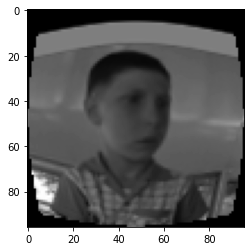

In [5]:
plt.imshow(GrayFrames_np[400], cmap=plt.get_cmap("gray"))


In [6]:
GrayFrames_np.shape

(3527, 96, 96)

## # The Illustration of Structural Similarity Index (SSIM)

In [7]:
# PAPER: http://www.cns.nyu.edu/pub/eero/wang03-reprint.pdf
# https://en.wikipedia.org/wiki/Structural_similarity

In [8]:
def illustrate_SSIM(idx1, idx2, idx3):

    img1 = img_as_float(GrayFrames_np[idx1])
    img2 = img_as_float(GrayFrames_np[idx2])
    img3 = img_as_float(GrayFrames_np[idx3])

    rows, cols = img1.shape

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 4),
                             sharex=True, sharey=True)
    ax = axes.ravel()

    mse_1 = mean_squared_error(img1, img1)
    ssim_1 = ssim(img1, img1, data_range=img1.max() - img1.min())

    mse_2 = mean_squared_error(img1, img2)
    ssim_2 = ssim(img1, img2, data_range=img2.max() - img2.min())

    mse_3 = mean_squared_error(img1, img3)
    ssim_3 = ssim(img1, img3, data_range=img3.max() - img3.min())

    label = 'MSE: {:.2f}, SSIM: {:.2f}'

    ax[0].imshow(img1, cmap=plt.cm.gray, vmin=0, vmax=1)
    ax[0].set_xlabel(label.format(mse_1, ssim_1))
    ax[0].set_title(f'Original image frame {idx1}')

    ax[1].imshow(img2, cmap=plt.cm.gray, vmin=0, vmax=1)
    ax[1].set_xlabel(label.format(mse_2, ssim_2))
    ax[1].set_title(f'Compared to frame {idx2}')

    ax[2].imshow(img3, cmap=plt.cm.gray, vmin=0, vmax=1)
    ax[2].set_xlabel(label.format(mse_3, ssim_3))
    ax[2].set_title(f'Compared to frame {idx3}')

    plt.tight_layout()
    plt.show()

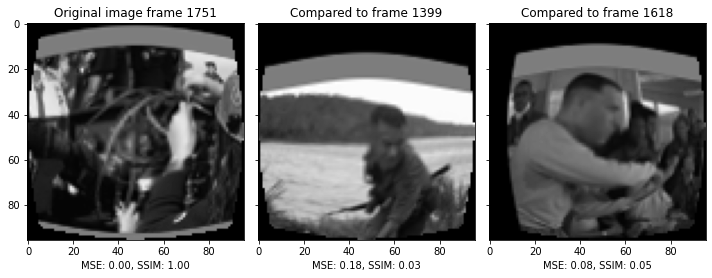

In [9]:
idx1 = np.random.randint(0, high=GrayFrames_np.shape[0])
idx2 = np.random.randint(0, high=GrayFrames_np.shape[0])
idx3 = np.random.randint(0, high=GrayFrames_np.shape[0])

illustrate_SSIM(idx1, idx2, idx3)

In [10]:
# Compared to Cosine Similarity

Aflat = np.hstack(GrayFrames_np[idx1])
Bflat = np.hstack(GrayFrames_np[idx2])
Cflat = np.hstack(GrayFrames_np[idx3])

dist1 = distance.cosine(Aflat, Aflat)
dist2 = distance.cosine(Aflat, Bflat)
dist3 = distance.cosine(Aflat, Cflat)

dist1, dist2, dist3

(0.0, 0.4612086473274395, 0.41511317089745947)

## # Similarity Matrix for SSIM

In [11]:
GrayFrames_np.shape

(3527, 96, 96)

In [12]:
# similarity_matrix = np.zeros((GrayFrames_np.shape[0], GrayFrames_np.shape[0]))
# similarity_matrix.shape

In [13]:
# np.fill_diagonal(similarity_matrix, 1)
# similarity_matrix

In [14]:
# for i in tqdm(range(similarity_matrix.shape[0])):
#     for k in range(similarity_matrix.shape[0]):
#         img1 = GrayFrames_np[i]
#         img2 = GrayFrames_np[k]
#         similarity_matrix[i,k] = ssim(img1, img2, data_range=img2.max() - img2.min())

In [15]:
# np.save(f'all_MovieFrames/SSIM_similarityMatrix.npy', similarity_matrix)

In [16]:
similarityMatrix = np.load('all_MovieFrames/SSIM_similarityMatrix.npy')

In [17]:
similarityMatrix.shape

(3527, 3527)

In [18]:
similarityMatrix

array([[1.        , 0.14117462, 0.08208579, ..., 0.02701189, 0.14859462,
        0.10398341],
       [0.13397965, 1.        , 0.16488872, ..., 0.17626862, 0.10147664,
        0.23762846],
       [0.06487132, 0.17974242, 1.        , ..., 0.26397237, 0.1244295 ,
        0.2204202 ],
       ...,
       [0.02267433, 0.18650071, 0.26077782, ..., 1.        , 0.09397326,
        0.18294643],
       [0.09183949, 0.10547251, 0.1208859 , ..., 0.09137429, 1.        ,
        0.10552367],
       [0.09705961, 0.22594679, 0.19621381, ..., 0.1614781 , 0.09641166,
        1.        ]])

### # Visualize Similar Frames: SSIM > epsilon

In [19]:
epsilon = 0.5  # threshold

In [20]:
similarFrames_idx = []
N = 0

for i in tqdm(range(similarityMatrix.shape[0])):
    for k in range(N, similarityMatrix.shape[0]):
        if similarityMatrix[i,k] >= epsilon and i!=k:
            similarFrames_idx.append((i,k))
    N += 1

100%|██████████| 3527/3527 [00:02<00:00, 1379.75it/s]


In [21]:
similarFrames_idx = np.array(similarFrames_idx)
similarFrames_idx.shape

(745, 2)

In [22]:
# # visualize those frames

# for ii in similarFrames_idx:
    
#     idx1 = ii[0]
#     idx2 = ii[1]

#     img1 = img_as_float(GrayFrames_np[idx1])
#     img2 = img_as_float(GrayFrames_np[idx2])

#     rows, cols = img1.shape

#     fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4),
#                              sharex=True, sharey=True)
#     ax = axes.ravel()

#     mse_1 = mean_squared_error(img1, img1)
#     ssim_1 = ssim(img1, img1, data_range=img1.max() - img1.min())

#     mse_2 = mean_squared_error(img1, img2)
#     ssim_2 = ssim(img1, img2, data_range=img2.max() - img2.min())

#     label = 'MSE: {:.2f}, SSIM: {:.2f}'

#     ax[0].imshow(img1, cmap=plt.cm.gray, vmin=0, vmax=1)
#     ax[0].set_xlabel(label.format(mse_1, ssim_1))
#     ax[0].set_title(f'Original image frame {idx1}')

#     ax[1].imshow(img2, cmap=plt.cm.gray, vmin=0, vmax=1)
#     ax[1].set_xlabel(label.format(mse_2, ssim_2))
#     ax[1].set_title(f'Compared to frame {idx2}')

#     plt.tight_layout()
#     plt.show()

### # Between All Frames (3527) (respectively [442, 432, 429, 479, 453, 430, 534, 328]) 

In [25]:
# Except the last 2 runs, the final target frame numbers correspond to the number of fMRI volumes. 
# However, the targets and RFsignals have the equal number of row for each run.

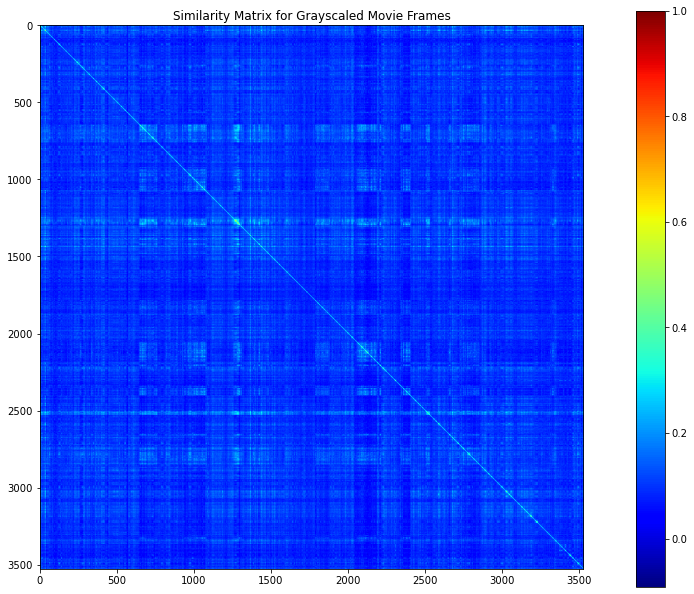

In [26]:
H1 = similarityMatrix

fig = plt.figure(figsize=(10, 10))

ax = fig.add_subplot(111)
ax.set_title('Similarity Matrix for Grayscaled Movie Frames')
plt.imshow(H1, cmap='jet')
ax.set_aspect('equal')

cax = fig.add_axes([0.30, 0.1, 0.78, 0.8])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.patch.set_alpha(0)
cax.set_frame_on(False)

plt.colorbar(orientation='vertical')
plt.show()

In [3]:
numberOfFrames = [451, 441, 438, 488, 462, 439, 543, 337] 
numberOfFrames = np.array(numberOfFrames) - 9
numberOfFrames

# Except the last 2 runs, the final target frame numbers correspond to the number of fMRI volumes. 
# However, the targets and RFsignals have the equal number of row for each run at the end.
# probably because of downsizing the videos accordingly 2s TR

array([442, 432, 429, 479, 453, 430, 534, 328])

### # Divide All Frames (3527) Into Chunks of 160  

In [37]:
# In Total 22 chunks. The last one has 167 frames.
21*160 + 167

3527

In [41]:
chunks = []
for i in range(22):
    chunks.append(160)
    
chunks[21] = 167

In [42]:
len(chunks)

22

In [44]:
SSIM = np.copy(similarityMatrix)
SSIM.shape

(3527, 3527)

In [47]:
epsilon = 0.5

similarity_idx = []

for i in tqdm(range(SSIM.shape[0])):
    for k in range(SSIM.shape[0]):
        if SSIM[i,k] >= epsilon:
            similarity_idx.append((i,k))

100%|██████████| 3527/3527 [00:05<00:00, 647.92it/s]


In [48]:
len(similarity_idx)

5023

In [49]:
for idx in similarity_idx:
    if idx[0] == idx[1]:
        SSIM[idx[0], idx[1]] = 0

In [50]:
np.sum(SSIM>=0.5)

1496

In [63]:
N = 0
ii = 0
record_idx = []

for idx in chunks:
    run = SSIM[:, N:N+idx]
    run[N:N+idx, :] = 0
    
#     record_idx.append((unravel_index(run.argmax(), run.shape)[0], unravel_index(run.argmax(), run.shape)[1] + N))
#     print(f'Chunk {ii+1} =', f' shape: {run.shape}, SSIM max and index: ({run.max()}, {record_idx[ii]})')
    
#     print(f'Chunk {ii+1} =', f' shape: {run.shape}, SSIM mean: {np.mean(run)}')
    
    print(f'Chunk {ii+1} =', f' shape: {run.shape}, Number of Frames (SSIM>=0.5): {np.sum(run.flatten()>=0.5)}')
    
    N += idx
    ii += 1

Chunk 1 =  shape: (3527, 160), Number of Frames (SSIM>=0.5): 83
Chunk 2 =  shape: (3527, 160), Number of Frames (SSIM>=0.5): 6
Chunk 3 =  shape: (3527, 160), Number of Frames (SSIM>=0.5): 4
Chunk 4 =  shape: (3527, 160), Number of Frames (SSIM>=0.5): 19
Chunk 5 =  shape: (3527, 160), Number of Frames (SSIM>=0.5): 62
Chunk 6 =  shape: (3527, 160), Number of Frames (SSIM>=0.5): 2
Chunk 7 =  shape: (3527, 160), Number of Frames (SSIM>=0.5): 50
Chunk 8 =  shape: (3527, 160), Number of Frames (SSIM>=0.5): 34
Chunk 9 =  shape: (3527, 160), Number of Frames (SSIM>=0.5): 113
Chunk 10 =  shape: (3527, 160), Number of Frames (SSIM>=0.5): 23
Chunk 11 =  shape: (3527, 160), Number of Frames (SSIM>=0.5): 35
Chunk 12 =  shape: (3527, 160), Number of Frames (SSIM>=0.5): 13
Chunk 13 =  shape: (3527, 160), Number of Frames (SSIM>=0.5): 19
Chunk 14 =  shape: (3527, 160), Number of Frames (SSIM>=0.5): 45
Chunk 15 =  shape: (3527, 160), Number of Frames (SSIM>=0.5): 26
Chunk 16 =  shape: (3527, 160), Numb

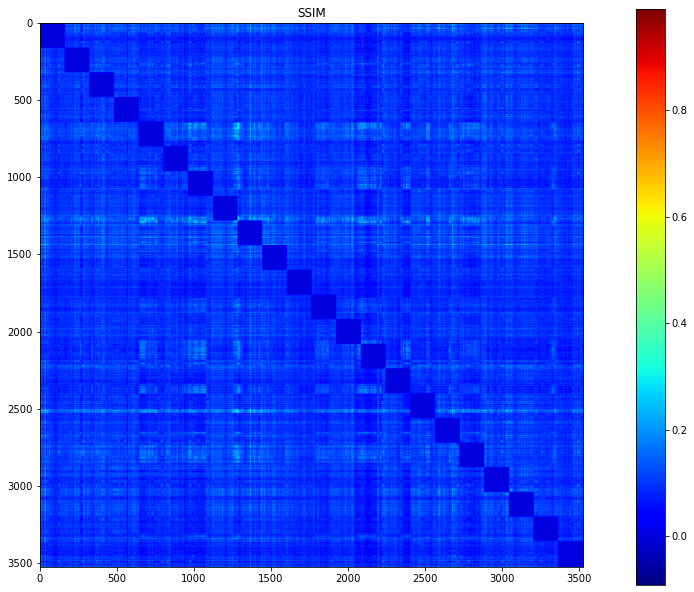

In [52]:
H1 = SSIM

fig = plt.figure(figsize=(10, 10))

ax = fig.add_subplot(111)
ax.set_title('SSIM')
plt.imshow(H1, cmap='jet')
ax.set_aspect('equal')

cax = fig.add_axes([0.30, 0.1, 0.78, 0.8])
cax.get_xaxis().set_visible(False)
cax.get_yaxis().set_visible(False)
cax.patch.set_alpha(0)
cax.set_frame_on(False)

plt.colorbar(orientation='vertical')
plt.show()

## # Choosing the Sixth Chunk as Test Set

In [59]:
idxOfFrames = []
record = 0

for n in chunks:
    idxOfFrames.append(n+record)
    record += n 

# idxOfFrames

[160,
 320,
 480,
 640,
 800,
 960,
 1120,
 1280,
 1440,
 1600,
 1760,
 1920,
 2080,
 2240,
 2400,
 2560,
 2720,
 2880,
 3040,
 3200,
 3360,
 3527]

In [60]:
run_2 = SSIM[:, idxOfFrames[4]:idxOfFrames[5]]
run_2.shape, np.sum(run_2>=0.5) 

((3527, 160), 2)

In [61]:
arr1, arr2 = np.where(run_2>=0.5)
arr1, arr2+idxOfFrames[4]

(array([1812, 2519]), array([865, 820]))

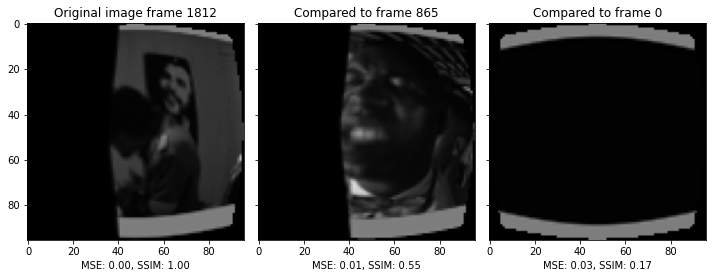

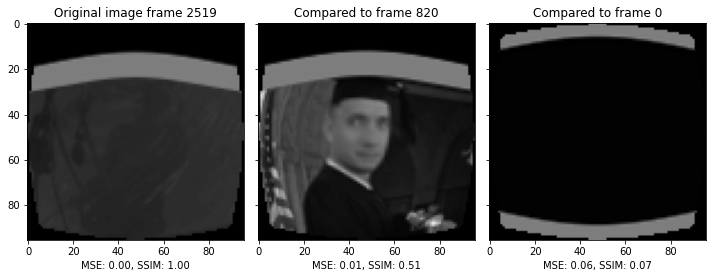

In [62]:
for n1, n2 in zip(arr1, arr2+160*5):
    
    idx1 = n1
    idx2 = n2
    idx3 = 0

    illustrate_SSIM(idx1, idx2, idx3)